In [1]:
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import transforms
from imutils import paths
from torch import optim
from torch import nn
import pandas as pd
import numpy as np
import torch
import cv2

In [2]:
SEP         = os.path.sep
ROOT_PATH   = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH   = f'{ROOT_PATH}/Datasets/TurtleFace'

args               = {}
args['seed']       = 999
args['n_samples']  = 3
args['device']     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['epochs']     = 15
args['batch_size'] = 16
args['lr']         = 1e-3
args               = edict(args)

In [3]:
image_paths = sorted(paths.list_images(f'{DATA_PATH}/images'))
label_paths = sorted(paths.list_files(f'{DATA_PATH}/labels', validExts = '.txt'))

In [4]:
names = ['name', 'x', 'y', 'w', 'h', 'path', 'img_w', 'img_h']
df = pd.read_csv(f'{DATA_PATH}/labels.csv', names = names, header = 0)
df['img_w'].mean(), df['img_h'].mean()

(1426.6531874405327, 951.4386298763083)

In [5]:
class TurtleDataset(Dataset):

    def __init__(self, image_paths, label_paths):

        self.image_paths = image_paths
        self.label_paths = label_paths

        self.transform   = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize((1430, 950)),
                            transforms.ToTensor()
                        ])

    def yolo_to_coord(self, yolo, orig):

        x, y, w, h     = yolo
        orig_w, orig_h = orig

        fix_x1, fix_x2 = (2*x + w) * orig_w / 2, (2*x - w) * orig_w / 2
        fix_y1, fix_y2 = (2*y + h) * orig_h / 2, (2*y - h) * orig_h / 2

        return (int(fix_x1), int(fix_x2), int(fix_y1), int(fix_y2))

    
    def draw_boxes(self, idx):
        
        image  = cv2.imread(self.image_paths[idx])
        image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        orig_h, orig_w   = image.shape[:2]
        image            = cv2.resize(image, (1430, 950), cv2.INTER_LINEAR)
        fixed_h, fixed_w = image.shape[:2]
        
        coords            = open(self.label_paths[idx], 'r').readline()
        boxes             = [list(map(float, coord.split())) for coord in coords]

        for box in boxes:

            lb, x, y, w, h = box.tolist()
        x1, x2, y1, y2    = self.yolo_to_coord((x, y, w, h), (fixed_w, fixed_h))
        ratio_w, ratio_h  = orig_w / fixed_w, orig_h / fixed_h
        
        rec               = cv2.rectangle(image, (int(x1), int(y1)),
                                          (int(x2), int(y2)), (255, 255, 0), 3)
        
        return rec, image, (x * ratio_w, y * ratio_h, w * ratio_w, h * ratio_h)
        

    def __len__(self):

        return len(self.image_paths)



    def __getitem__(self, idx):

        rec, image, coords = self.draw_boxes(idx)
        image = self.transform(image)

        return rec, image, coords        

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(image_paths, label_paths, test_size = 0.2,
                                                      shuffle = True, random_state = args.seed)
train_x, test_x , train_y, test_y  = train_test_split(train_x, train_y, test_size = 0.25,
                                                      shuffle = True, random_state = args.seed) 

In [7]:
train_dataset = TurtleDataset(train_x, train_y)
test_dataset  = TurtleDataset(test_x ,  test_y)
valid_dataset = TurtleDataset(valid_x, valid_y)

train_loader  = DataLoader(train_dataset, batch_size = args.batch_size, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size = args.batch_size, shuffle = False)
valid_loader  = DataLoader(valid_dataset, batch_size =               1, shuffle = False)

['0', '0.269174', '0.336129', '0.302360', '0.283452']
['0', '0.497642', '0.472583', '0.551887', '0.838443']
['0', '0.356936', '0.481696', '0.176301', '0.258189']
['0', '0.395280', '0.495577', '0.129794', '0.199016']
['0', '0.492335', '0.481132', '0.576651', '0.903564']
['0', '0.488032', '0.475532', '0.540957', '0.551064']
['0', '0.761905', '0.223104', '0.329806', '0.252205']
['0', '0.498073', '0.466281', '0.548491', '0.836224']
['0', '0.594340', '0.671871', '0.174528', '0.238660']
['0', '0.734104', '0.377649', '0.251445', '0.273603']
['0', '0.659592', '0.252128', '0.147316', '0.261702']
['0', '0.524301', '0.356863', '0.224621', '0.309804']
['0', '0.515487', '0.374507', '0.237463', '0.334649']
['0', '0.412736', '0.359000', '0.221698', '0.258943']
['0', '0.824785', '0.470135', '0.158557', '0.188825']
['0', '0.689269', '0.414253', '0.123821', '0.155583']


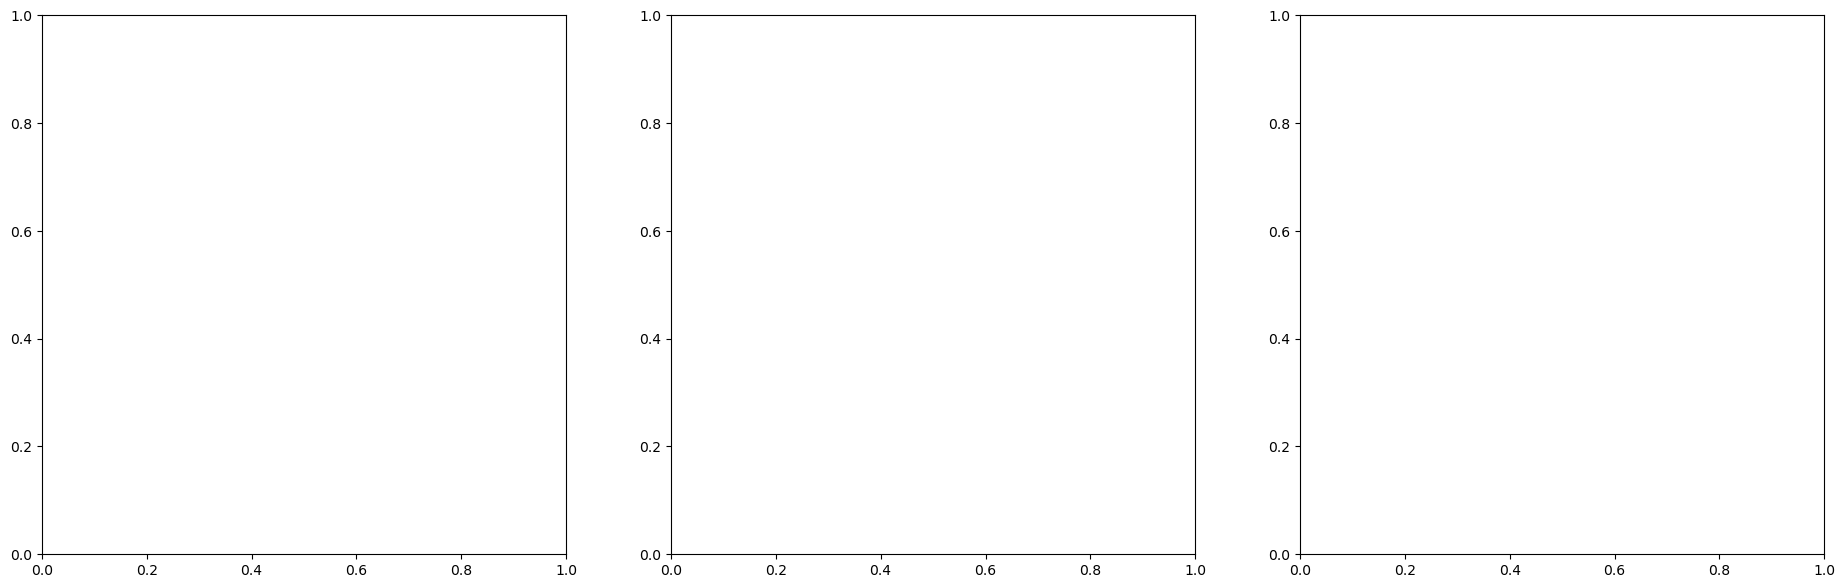

In [8]:
sample        = next(iter(train_loader))
random_idx    = np.random.randint(0, len(sample), args.n_samples)
_, axes       = plt.subplots(1, args.n_samples, figsize = (23, 7))

for idx, ax in zip(random_idx, axes):

    rec, _, _ = sample
    rec       = rec[idx]
    